# Salt_Obs_Pan005 Surface

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe
import gsw

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/38589/status,
Dashboard: /proxy/38589/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33475,Workers: 0
Dashboard: /proxy/38589/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35165,Total threads: 1
Dashboard: /proxy/39037/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:40491,


### Importing the data

In [3]:
# Model data
lat_slice = slice(None,-39)
paths_model = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/outpu*/*.ocean_month_z.nc'))

In [4]:
# Importing obs
#shelf = xr.open_dataset('/g/data/g40/akm157/data/schmidtko/AASW_Temp_Salt.nc', chunks='auto')['AS'].sel(lat=lat_slice)
deep =  xr.open_dataset('/g/data/ik11/observations/woa23/woa23_decav_s00_04.nc', decode_times=False)['s_an'].sel(lat=lat_slice)

In [5]:
# Loading model data
def preprocess_model(ds):
    ds = ds[['so']].sel(yh=slice(None,-39)).isel(z_l=0)
    return ds
    
model = xr.open_mfdataset(paths_model, preprocess = preprocess_model, chunks = 'auto')

## Getting surface salt

In [6]:
# Taking the average of the ten years after spin up
salt_model_ave = model.sel(time=slice('2006-01-01','2010-12-31')).mean(dim='time').to_array()

In [7]:
salt_model_ave

<xarray.DataArray (variable: 1, yh: 1641, xh: 7200)> Size: 47MB
dask.array<stack, shape=(1, 1641, 7200), dtype=float32, chunksize=(1, 564, 600), chunktype=numpy.ndarray>
Coordinates:
  * xh        (xh) float64 58kB -280.0 -279.9 -279.9 ... 79.87 79.92 79.97
  * yh        (yh) float64 13kB -81.1 -81.08 -81.06 ... -39.09 -39.05 -39.01
    z_l       float64 8B 0.5413
  * variable  (variable) object 8B 'so'

In [8]:
deep

<xarray.DataArray 's_an' (time: 1, depth: 102, lat: 204, lon: 1440)> Size: 120MB
[29963520 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 816B -89.88 -89.62 -89.38 ... -39.62 -39.38 -39.12
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * depth    (depth) float32 408B 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time     (time) float32 4B 4.614e+03
Attributes:
    standard_name:  sea_water_practical_salinity
    long_name:      Objectively analyzed mean fields for sea_water_practical_...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          1

In [9]:
salt_WOA_ave = deep.isel(depth=0).drop_vars('time')

In [10]:
salt_WOA_ave

<xarray.DataArray 's_an' (time: 1, lat: 204, lon: 1440)> Size: 1MB
[293760 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 816B -89.88 -89.62 -89.38 ... -39.62 -39.38 -39.12
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
    depth    float32 4B 0.0
Dimensions without coordinates: time
Attributes:
    standard_name:  sea_water_practical_salinity
    long_name:      Objectively analyzed mean fields for sea_water_practical_...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          1

## Aligning coordinates and regridding

In [11]:
def shift_lon_minus280_80(lon):
    """
    Shift longitudes to -280 -> 80 range.
    Works whether input is 0-360 or -180-180.
    """
    lon = lon % 360  # ensure 0-360
    lon_new = lon.copy()
    lon_new[lon > 80] -= 360  # shift values > 80 into negative range
    return lon_new

In [12]:
# Deep
lon_deep_new = shift_lon_minus280_80(salt_WOA_ave.lon)
salt_WOA_ave = salt_WOA_ave.assign_coords(lon=lon_deep_new).sortby("lon")

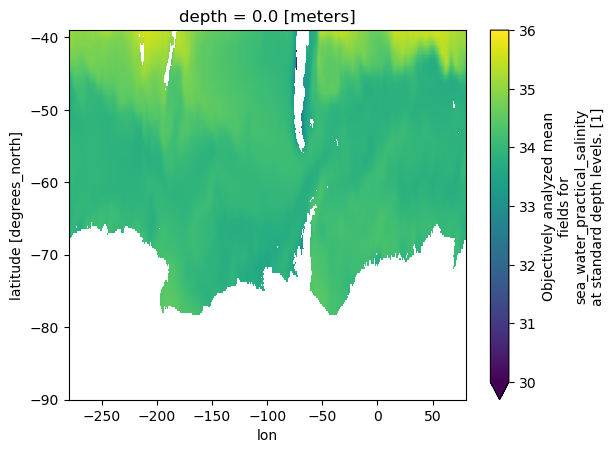

In [13]:
salt_WOA_ave.plot(vmin=30,vmax=36)

In [14]:
salt_model_ave = salt_model_ave.load()

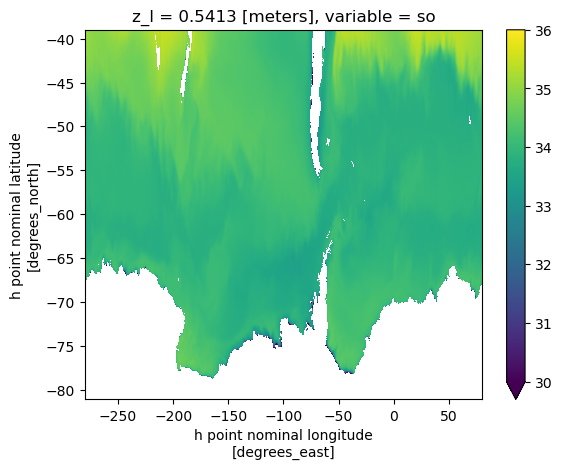

In [15]:
salt_model_ave.plot(vmin=30,vmax=36)

In [21]:
# Commented out bc this has already been saved
#salt_WOA_ave.to_netcdf('/g/data/x77/kc5856/thesis_model_validation/WOA23_surface_salt.nc')

Model is on 1/10th degree. 
WOA is on 1/4 degree.  
So we need to do some regridding.

In [16]:
import xesmf as xe

In [17]:
salt_model_ave_new = salt_model_ave.rename({'xh': 'lon', 'yh': 'lat'}) # comment out if already done this session

In [18]:
# Build regridder from model grid -> obs grid
# xESMF expects coords named 'lon' and 'lat' (or specify lon/lat dims explicitly).
regridder = xe.Regridder(salt_model_ave_new, salt_WOA_ave, method='conservative')  # or 'bilinear'

# Regrid the high-res model onto the obs grid
model_on_obs = regridder(salt_model_ave_new)

In [19]:
# compute anomaly
anomaly = model_on_obs - salt_WOA_ave   # model minus obs (change sign if you prefer obs-model)

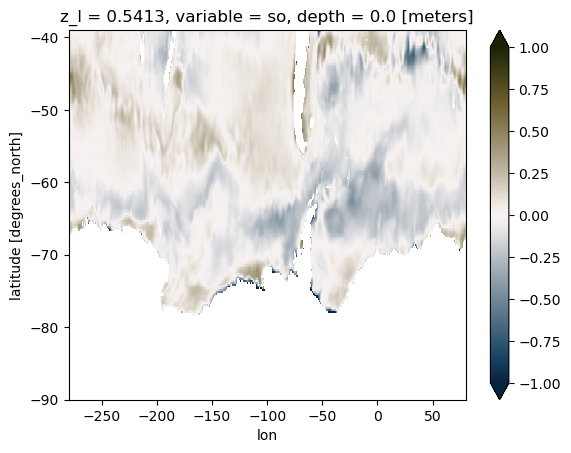

In [20]:
anomaly.plot(vmin=-1,vmax=1,cmap=cm.cm.diff) # checking -1 to 1 range against Schmidt et al, 2025.

In [21]:
# Save anomalies
anomaly.to_netcdf('/g/data/x77/kc5856/thesis_model_validation/pan005_control_WOA23_surface_salt_anomaly.nc')

In [23]:
# save model data 
model_on_obs.to_netcdf('/g/data/x77/kc5856/thesis_model_validation/pan005_control_surface_salt_regridded.nc')
salt_model_ave.to_netcdf('/g/data/x77/kc5856/thesis_model_validation/pan005_control_surface_salt_originalgrid.nc')

## Plotting

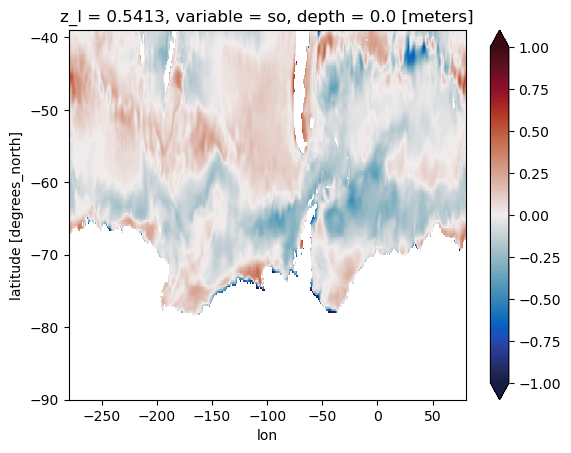

In [22]:
# Quick plot to check 
anomaly.plot(vmin=-1,vmax=1,cmap=cm.cm.balance)

Not running the big plot below - code is just there if wanted.

In [39]:
# Shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [40]:
# Shelf contour
depth = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
land_mask = (0 * depth).fillna(1)
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6_01')

In [41]:
import matplotlib.patches as mpatches

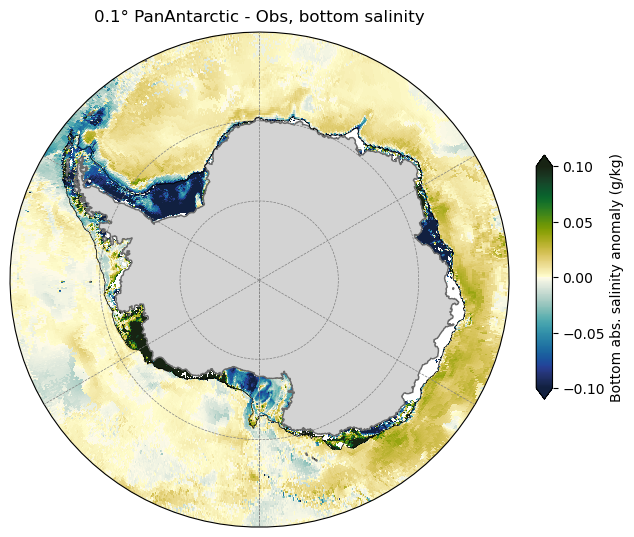

In [45]:
projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    
# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='lightgrey',
                   zorder=3,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Add a light grey circle patch to get last bit of land
circle_patch = mpatches.Circle(
    (0, 0),  # center at South Pole in projection coordinates
    radius=1000000,  # adjust radius until circle ends around -80° latitude
    facecolor='lightgrey',
    edgecolor=None,
    zorder=2,
    transform=ccrs.SouthPolarStereo()
)
ax.add_patch(circle_patch)

#Plotting
anomaly.plot(
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-.1,
    vmax=.1,
    extend="both",
    cmap=cm.cm.delta, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Bottom abs. salinity anomaly (g/kg)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
    zorder= 1
)


# Longitudes
for lon in range(-180, 181, 60):
    ax.plot([lon, lon], [-90, -59],
            transform=ccrs.PlateCarree(),
            color="gray", linestyle="--", linewidth=0.5, zorder=20)

# Latitudes
for lat in (-80, -70, -55):
    lons = np.linspace(-280, 80, 400)
    ax.plot(lons, [lat]*len(lons),
            transform=ccrs.PlateCarree(),
            color="gray", linestyle="--", linewidth=0.5, zorder=20)


# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=1, transform = ccrs.PlateCarree(), zorder=15)
# Shelf contour
ax.contour(shelf_mask['xh'], shelf_mask['yh'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.5,transform = ccrs.PlateCarree(), zorder=15)


plt.title("0.1° PanAntarctic - Obs, bottom salinity");